# CIFAR-10 Image classification using CNN's
By Blasko, Oliver


## Introduction
In this notebook we'll explore the CIFAR-10(Canadian Institute For Advanced Research) data set. CIFAR-10 is a labeled subset of the 80 million tiny images dataset. The dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

We'll then build a 3 different CNN-based classification models to evaluate performances on this data set. We'll be building our models using the Keras framework. For more information on the framework, you can refer to the documentation [here](https://keras.io/). Here is the list of models we'll try out and compare their results:

- CNN with 1 Convolutional Layer
- CNN with 3 Convolutional Layer
- CNN with 4 Convolutional Layer

We'll train the models on training data( 50000 images ) and evaluate each model on data that the models has never seen before - testing data( 10000 images ). We'll train the models for **20 epochs** with batch size of **35 images** . The models will be compiled with **categorical_crossentropy loss function** and **Adam optimizer**.

In [105]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils

# NN layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

#conf matrix
from sklearn.metrics import confusion_matrix

In [94]:
# helper function for printing the loss curve of already trained model
def print_loss_curve(output):
    plt.figure(figsize=[14,10])
    plt.subplot(211)
    plt.plot(output.history['loss'],'r',linewidth=3.0)
    plt.plot(output.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)

In [93]:
# helper function for printing the accuaracy curve of already trained model
def print_acc_curve(output):
    plt.figure(figsize=[14,10])
    plt.subplot(212)
    plt.plot(output.history['acc'],'r',linewidth=3.0)
    plt.plot(output.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)

In [108]:
# helper function for plotting the confusion matrix
def print_confusion_matrix( test_labels, predictions, class_names):
    plt.figure(figsize=(7, 6))
    plt.title('Confusion matrix', fontsize=16)
    plt.imshow(confusion_matrix(test_labels, predictions))
    plt.xticks(np.arange(10), class_names, rotation=45, fontsize=12)
    plt.yticks(np.arange(10), class_names, fontsize=12)
    plt.colorbar()
    plt.show()

## Importing the CIFAR-10 data set
At first we were working with data set downloaded from the official [site](site) of the data set, but after doing some research we found out that this particular data set is already prepared in a form of training and testing sets and ready to load from keras itself.

In [78]:
#Load the CIFAR-10 data

from keras.datasets import cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

## Data exploratory analysis

Let's explore the format of the dataset before training the model. The following shows there are 50,000 images in the training set, with each image represented as 32 x 32 pixels:

In [79]:
print(train_images.shape)

(50000, 32, 32, 3)


And 10,000 images in the testing set represented as 32 x 32 pixels.

In [80]:
print(test_images.shape)

(10000, 32, 32, 3)


Each label is an integer between 0 and 9:

In [81]:
print(train_labels.shape)

(50000, 1)


Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [82]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

Let's display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

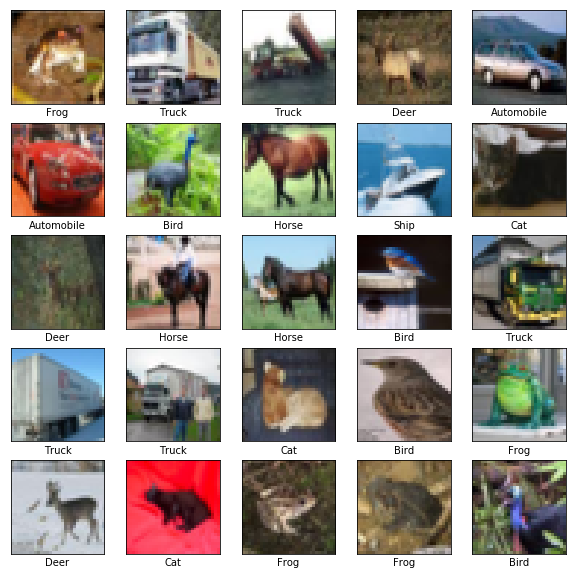

In [83]:
# labels for plotting
train_labels_plt = train_labels.reshape(50000)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels_plt[i]])
plt.show()

## Preprocessing the data

### Encoding the categorical target variables
As we've showed earlier the label images are stored as integer values between 0-9. Let's transform them into categorical variables with one hot encode technique using keras bult in function [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) 

In [84]:
train_labels = np_utils.to_categorical(train_labels)
test_labels = np_utils.to_categorical(test_labels)

In [85]:
print(train_labels)
print()
print(test_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


As we can see the labels are now categorical.

The data must be preprocessed before training the network. If we inspect the first image in the training set, we will see that the pixel values fall in the range of 0 to 255:

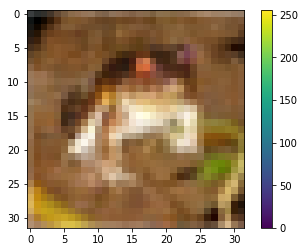

In [86]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Let's scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the training set and the testing set are preprocessed in the same way:

In [87]:
train_images = train_images / 255.0

test_images = test_images / 255.0

## Buliding the models

We'll be using the model architectures that were used and described in this [article](https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d) for solving similar probelm as ours with similar data set - Fashion-MNIST - images with 10 different classes of clothes.

In [95]:
#initializing training parameters
img_rows = 32
img_cols = 32
input_shape = (img_rows, img_cols, 3)
batch_size = 35
epochs = 20

### CNN with 1 Convolutional Layer

In [114]:

#create sequential model
cnn1 = Sequential()

#first convolutional layer
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#max pooling operation for spatial data
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
#applies Dropout to the input
cnn1.add(Dropout(0.2))

#flattens the input
cnn1.add(Flatten())

#regular densely-connected NN layer
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(10, activation='softmax'))

#compling the model with ADAM optimizer and categorical_crossentropy loss function
cnn1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [115]:
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               921728    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                1290      
Total params: 923,914
Trainable params: 923,914
Non-trainable params: 0
_________________________________________________________________


In [116]:
%%time
history_cnn1 = cnn1.fit(train_images, train_labels, batch_size = batch_size, epochs = epochs, validation_data = (test_images, test_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 53s 1ms/step - loss: 1.4501 - acc: 0.4824 - val_loss: 1.2522 - val_acc: 0.5583
Epoch 2/20
50000/50000 [==============================] - 50s 1ms/step - loss: 1.1507 - acc: 0.5955 - val_loss: 1.1766 - val_acc: 0.5893
Epoch 3/20
50000/50000 [==============================] - 48s 961us/step - loss: 1.0290 - acc: 0.6397 - val_loss: 1.0706 - val_acc: 0.6239
Epoch 4/20
50000/50000 [==============================] - 50s 994us/step - loss: 0.9401 - acc: 0.6701 - val_loss: 1.0445 - val_acc: 0.6410
Epoch 5/20
50000/50000 [==============================] - 54s 1ms/step - loss: 0.8656 - acc: 0.6955 - val_loss: 0.9917 - val_acc: 0.6578
Epoch 6/20
50000/50000 [==============================] - 47s 949us/step - loss: 0.8015 - acc: 0.7184 - val_loss: 1.0149 - val_acc: 0.6556
Epoch 7/20
50000/50000 [==============================] - 46s 924us/step - loss: 0.7524 - acc: 0.7348 - val_loss: 0.9884 -

In [117]:
cnn1_test_loss, cnn1_test_acc = cnn1.evaluate(test_images, test_labels)
print("CNN with 1 Convolutional Layer model test loss: " + str(cnn1_test_loss))
print("CNN with 1 Convolutional Layer model test accuracy: " + str(cnn1_test_acc))

10000/10000 [==============================] - 3s 271us/step
CNN with 1 Convolutional Layer model test loss: 1.3985189600944519
CNN with 1 Convolutional Layer model test accuracy: 0.6495


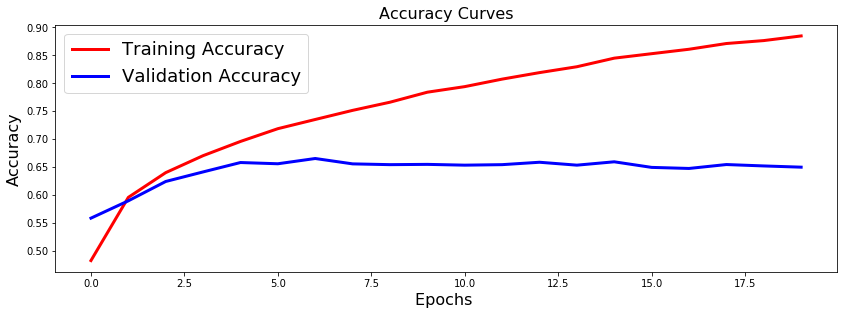

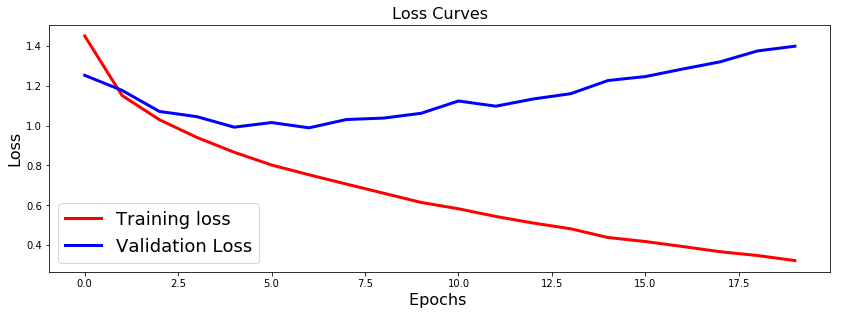

In [118]:
print_acc_curve(history_cnn1)
print_loss_curve(history_cnn1)

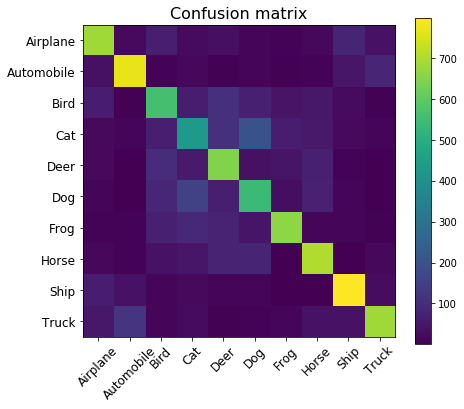

In [119]:
cnn1_test_predictions = cnn1.predict_proba(test_images)
print_confusion_matrix( test_labels.argmax(axis=1), cnn1_test_predictions.argmax(axis=1), class_names)

### CNN with 3 Convolutional Layer

In [99]:
#create sequential model
cnn3 = Sequential()

#first convolutional layer
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#max pooling operation for spatial data
cnn3.add(MaxPooling2D((2, 2)))
#applies Dropout to the input
cnn3.add(Dropout(0.25))

#second convolutional layer
cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(0.25))

#third convolutional layer
cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn3.add(Dropout(0.4))

#flattens the input
cnn3.add(Flatten())

#regular densely-connected NN layer
cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dropout(0.3))
cnn3.add(Dense(10, activation='softmax'))

#compling the model with ADAM optimizer and categorical_crossentropy loss function
cnn3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [100]:
cnn3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 4, 128)         73856     
__________

In [104]:
%%time
history_cnn3 = cnn3.fit(train_images, train_labels, batch_size = batch_size, epochs = epochs, validation_data = (test_images, test_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 76s 2ms/step - loss: 1.6357 - acc: 0.3940 - val_loss: 1.2745 - val_acc: 0.5533
Epoch 2/20
50000/50000 [==============================] - 69s 1ms/step - loss: 1.2922 - acc: 0.5384 - val_loss: 1.1390 - val_acc: 0.6038
Epoch 3/20
50000/50000 [==============================] - 74s 1ms/step - loss: 1.1743 - acc: 0.5833 - val_loss: 1.0139 - val_acc: 0.6479
Epoch 4/20
50000/50000 [==============================] - 79s 2ms/step - loss: 1.0958 - acc: 0.6135 - val_loss: 0.9429 - val_acc: 0.6703
Epoch 5/20
50000/50000 [==============================] - 74s 1ms/step - loss: 1.0372 - acc: 0.6365 - val_loss: 0.9232 - val_acc: 0.6740
Epoch 6/20
50000/50000 [==============================] - 75s 1ms/step - loss: 0.9952 - acc: 0.6507 - val_loss: 0.8910 - val_acc: 0.6926
Epoch 7/20
50000/50000 [==============================] - 77s 2ms/step - loss: 0.9581 - acc: 0.6659 - val_loss: 0.8646 - val_acc

In [106]:
cnn3_test_loss, cnn3_test_acc = cnn3.evaluate(test_images, test_labels)
print("CNN with 3 Convolutional Layer model test loss: " + str(cnn3_test_loss))
print("CNN with 3 Convolutional Layer model test accuracy: " + str(cnn3_test_acc))

10000/10000 [==============================] - 4s 370us/step
CNN with 3 Convolutional Layer model test loss: 0.7684598084449769
CNN with 3 Convolutional Layer model test accuracy: 0.7381


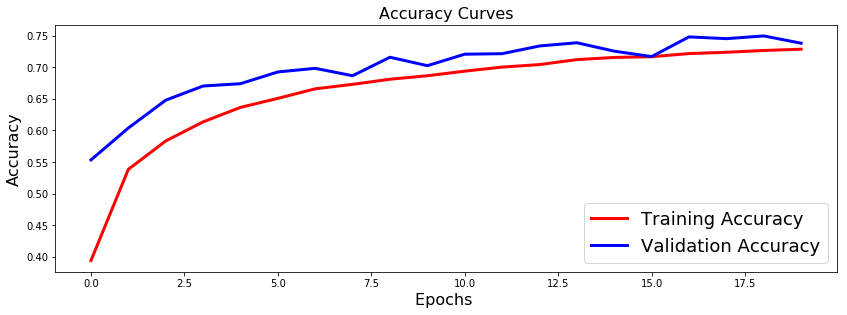

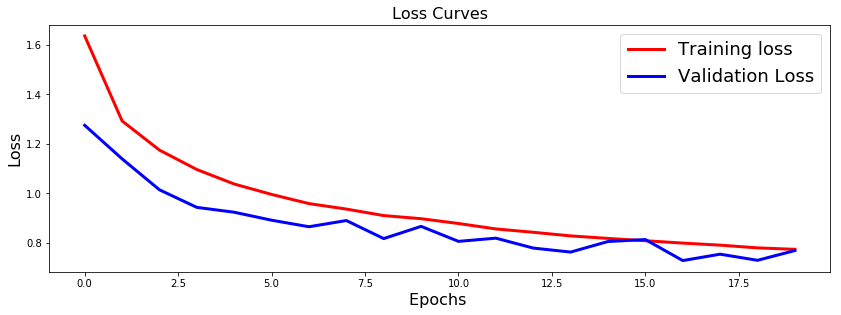

In [107]:
print_acc_curve(history_cnn3)
print_loss_curve(history_cnn3)

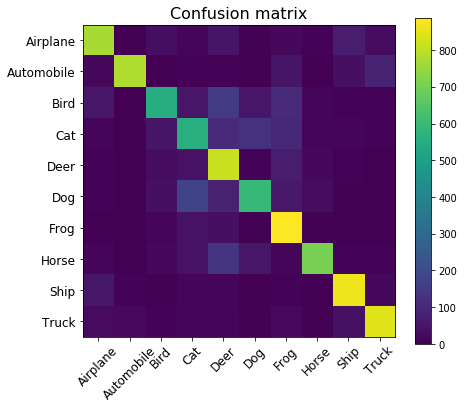

In [112]:
cnn3_test_predictions = cnn3.predict_proba(test_images)
print_confusion_matrix( test_labels.argmax(axis=1), cnn3_test_predictions.argmax(axis=1), class_names)

### CNN with 4 Convolutional Layer

In [89]:
#create sequential model
cnn4 = Sequential()

#first convolutional layer
cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#normalizes the activations of the previous layer at each batch
cnn4.add(BatchNormalization())

#second convolutional layer
cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
#max pooling operation for spatial data
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
#applies Dropout to the input
cnn4.add(Dropout(0.25))

#third convolutional layer
cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.25))

#fourth convolutional layer
cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

#flattens the input
cnn4.add(Flatten())

#regular densely-connected NN layer
cnn4.add(Dense(512, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))

cnn4.add(Dense(128, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))

cnn4.add(Dense(10, activation='softmax'))

#compling the model with ADAM optimizer and categorical_crossentropy loss function
cnn4.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [101]:
cnn4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 64)        18496     
__________

In [90]:
%%time
history_cnn4 = cnn4.fit(train_images, train_labels, batch_size = batch_size, epochs = epochs, validation_data = (test_images, test_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 297s 6ms/step - loss: 1.6764 - acc: 0.4224 - val_loss: 1.2167 - val_acc: 0.5639
Epoch 2/20
50000/50000 [==============================] - 322s 6ms/step - loss: 1.1701 - acc: 0.5877 - val_loss: 1.0388 - val_acc: 0.6273
Epoch 3/20
50000/50000 [==============================] - 319s 6ms/step - loss: 1.0089 - acc: 0.6475 - val_loss: 1.2674 - val_acc: 0.5732
Epoch 4/20
50000/50000 [==============================] - 292s 6ms/step - loss: 0.9075 - acc: 0.6852 - val_loss: 2.3300 - val_acc: 0.3687
Epoch 5/20
50000/50000 [==============================] - 313s 6ms/step - loss: 0.8478 - acc: 0.7074 - val_loss: 0.7600 - val_acc: 0.7354
Epoch 6/20
50000/50000 [==============================] - 289s 6ms/step - loss: 0.7934 - acc: 0.7273 - val_loss: 0.6608 - val_acc: 0.7725
Epoch 7/20
50000/50000 [==============================] - 294s 6ms/step - loss: 0.7398 - acc: 0.7462 - val_loss: 0.7149 - 

In [97]:
cnn4_test_loss, cnn4_test_acc = cnn4.evaluate(test_images, test_labels)
print("CNN with 4 Convolutional Layer model test loss: " + str(cnn4_test_loss))
print("CNN with 4 Convolutional Layer model test accuracy: " + str(cnn4_test_acc))

CNN with 4 Convolutional Layer model test loss: 0.5139848855018616
CNN with 4 Convolutional Layer model test accuracy: 0.8236


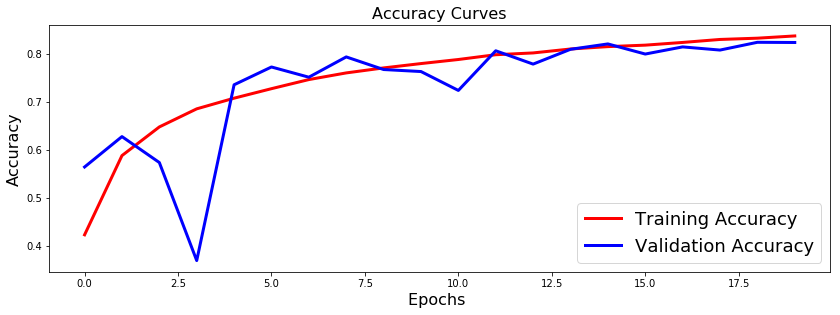

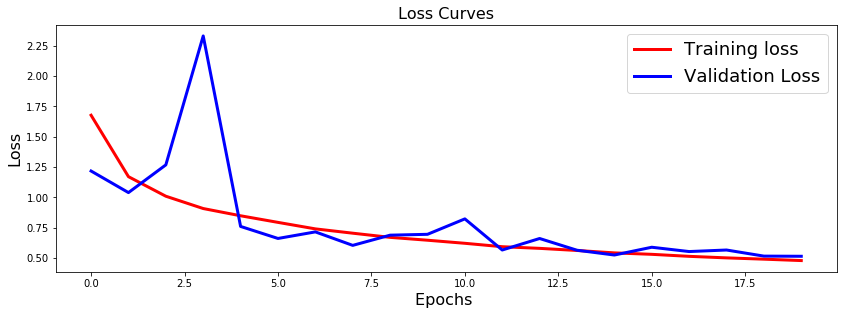

In [98]:
print_acc_curve(history_cnn4)
print_loss_curve(history_cnn4)

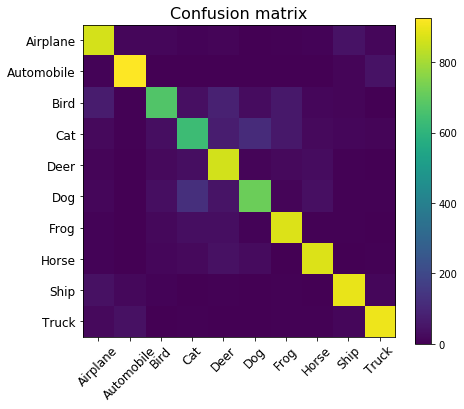

In [113]:
cnn4_test_predictions = cnn4.predict_proba(test_images)
print_confusion_matrix( test_labels.argmax(axis=1), cnn4_test_predictions.argmax(axis=1), class_names)

## Evaluation of the models
Here is the evaluation table of our models:

| Model        | Accuracy -- testing data           | Loss -- testing data  | Accuracy -- training data           | Loss -- training data  | Training time |
| ------------- | ------------- | ----- | ----- | ----- | ----- |
| CNN with 1 Convolutional Layer      | 0.650 | 1.398  | 0.884 | 0.321 | 16min 35s |
| CNN with 3 Convolutional Layer     |  0.7381      |  0.768  | 0.729 | 0.769 | 1h 2min 32s 
| CNN with 4 Convolutional Layer |  0.824     | 0.514    | 0.837 | 0.514 | 1h 42min 11s

## Conclusion
We trained and evaluated 3 different CNN-based classification models. As it is shown in the table above we found out that that the best performing model for CIFAR-10 data set is CNN with 4 Convolutional Layer with final accuracy of **0.824** and final loss of **0.514**(testing data). If we look at the table we can observe that with higher number of convolutional layers the model becomes more accurate. We can also observe that in the case of the CNN with 1 Convolutional Layer model there is a huge difference between the accuracy of testing vs training data. It looks like that this model over-fitted the data so it will not be practical to use it. However our last model - CNN with 4 Convolutional Layer is doing pretty good job and with little tweaks and finding the optimal parameters( increasing training epochs, different dropout rates, etc.) could be put into the practical use of classifying images in this data set.